AniList.co offers a free GraphQL API with loads of cool info about anime.

As a anime fan, I have a few questions about trends in anime popularity that the pre-canned stats on these website don't answer such as:

* Are certain anime relatively more popular in some seasons than others
* Are there any interesting trends in popularity of certain genres especially since the coronavirus pandemic
* Some anime are based on manga, and some are original. Are there certain source material types for anime that do better than others?

Let's see if we can find some cool insights!

On the AniList API, the `media` page which has basic info about virtually every anime.

With a little time looking at the documentation i was able to set up a request filtered to:

* Anime Only
* Japanese Made Only
* Start Date after Dec 31, 2012
* Aired on TV

In [1]:
import requests
def make_request(page_num,media_type):
    query = '''
    query ( $page: Int, $perPage: Int
  , $startDate_greater: FuzzyDateInt
,$countryOfOrigin:CountryCode
,$type:MediaType) {
        Page (page: $page, perPage: $perPage) {
            pageInfo {
                total
                currentPage
                lastPage
                hasNextPage
                perPage
            }
            media (startDate_greater:$startDate_greater,
            countryOfOrigin:$countryOfOrigin,
            type:$type) {
                id
                title {
                    english
                    native
                }
                season
                seasonYear
                type
                format
                status
                episodes
                duration
                chapters
                volumes
                isAdult
                averageScore
                popularity
                source
                countryOfOrigin
                isLicensed
                genres
                startDate {
                    day
                    month
                    year
                  }
                endDate {
                    day
                    month
                    year
                  }
            }
        }
    }
    '''
    variables = {
        "startDate_greater": 20121231 # Fuzzy Date for Dec 31, 2012
  ,"countryOfOrigin": "JP"
  ,"type": media_type
  ,"page": page_num
  ,"perPage": 500
  ,"format": "TV"
    }
    
    url = 'https://graphql.anilist.co'

    response = requests.post(url, json={'query': query, 'variables': variables})
    # response = requests.post(url, json={'query': query, 'variables': variables},verify=False)
    return response

Testing that function, I was getting some weird responses with anything more than 50 records per page. So I'll limit `perPage` to 50.

Let's then loop that 9999 times use the handy `hasNextPage` attribute to break the loop. And throw in an `if` statement in case we get a bad response that's not `=200`

In [3]:
import json
import pandas as pd
from IPython.display import clear_output
df_media=pd.DataFrame()

hasNextPage=True
for i in range(1,9999):
    clear_output()
    print(i)
    response=make_request(i,"ANIME")
    json_data = json.loads(response.text)
    if response.status_code==200:
        df_new=pd.json_normalize(json_data['data']['Page']['media'], meta  =[['english', 'native']])
        if len(json_data['data']['Page']['media'])>0:
            df_media=pd.concat([df_media,df_new])
        if json_data['data']['Page']['pageInfo']['hasNextPage']==False:
            break
df_media.reset_index(inplace=True,drop=True)
df_media.sort_values(['startDate.year','startDate.month','startDate.day'])
df_media

179


,id,season,seasonYear,type,format,status,episodes,duration,chapters,volumes,...,isLicensed,genres,title.english,title.native,startDate.day,startDate.month,startDate.year,endDate.day,endDate.month,endDate.year
0,3786,WINTER,2021.0,ANIME,MOVIE,FINISHED,1.0,155.0,None,None,...,True,"[Action, Drama, Mecha, Psychological, Sci-Fi]",Evangelion: 3.0+1.0 Thrice Upon a Time,シン・エヴァンゲリオン劇場版:||,8.0,3.0,2021,8.0,3.0,2021.0
1,9260,WINTER,2016.0,ANIME,MOVIE,FINISHED,1.0,64.0,None,None,...,True,"[Action, Drama, Ecchi, Mystery, Psychological,...",Kizumonogatari Part 1: Tekketsu,傷物語〈Ⅰ鉄血篇〉,8.0,1.0,2016,8.0,1.0,2016.0
2,9479,FALL,2013.0,ANIME,TV,FINISHED,13.0,24.0,None,None,...,True,"[Action, Sci-Fi]",Coppelion,コッペリオン,3.0,10.0,2013,25.0,12.0,2013.0
3,9488,SPRING,2019.0,ANIME,MOVIE,FINISHED,1.0,48.0,None,None,...,True,"[Action, Sci-Fi]",None,センコロール2,29.0,6.0,2019,29.0,6.0,2019.0
4,9851,SUMMER,2013.0,ANIME,SPECIAL,FINISHED,1.0,6.0,None,None,...,True,"[Action, Comedy, Hentai, Mecha]",None,オーパーツ オーマン,3.0,7.0,2013,3.0,7.0,2013.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,115918,WINTER,2018.0,ANIME,MOVIE,FINISHED,1.0,120.0,None,None,...,True,"[Action, Comedy, Mecha, Sci-Fi]",None,フルメタル・パニック！イントゥ・ザ・ブルー,20.0,1.0,2018,20.0,1.0,2018.0
4496,115925,None,NaN,ANIME,ONA,FINISHED,1.0,1.0,None,None,...,True,"[Comedy, Slice of Life]",None,かくしごとPV,16.0,6.0,2016,16.0,6.0,2016.0
4497,115927,WINTER,2019.0,ANIME,SPECIAL,FINISHED,1.0,2.0,None,None,...,True,[Comedy],None,劇場版 幼女戦記 マナー映像,8.0,2.0,2019,8.0,2.0,2019.0
4498,115931,None,NaN,ANIME,MUSIC,FINISHED,1.0,4.0,None,None,...,True,[],None,ヒトガタ,20.0,2.0,2019,20.0,2.0,2019.0


Okay awesome, that looks good.

I want to see if certain genres are more popular in different seasons of the year.
Let's see what those columns look like.

In [3]:
display(df_media[["title.english","title.native",'genres']])

,title.english,title.native,genres
0,Evangelion: 3.0+1.0 Thrice Upon a Time,シン・エヴァンゲリオン劇場版:||,"[Action, Drama, Mecha, Psychological, Sci-Fi]"
1,Kizumonogatari Part 1: Tekketsu,傷物語〈Ⅰ鉄血篇〉,"[Action, Drama, Ecchi, Mystery, Psychological,..."
2,Coppelion,コッペリオン,"[Action, Sci-Fi]"
3,None,センコロール2,"[Action, Sci-Fi]"
4,None,オーパーツ オーマン,"[Action, Comedy, Hentai, Mecha]"
...,...,...,...
6698,None,Still Life,[]
6699,None,暁の鎮魂歌,[Drama]
6700,White Midnight,白夜,"[Action, Adventure, Fantasy]"
6701,None,Paradox Live THE ANIMATION,[Music]


We've got multiple genres for each row in the `genres` column, so let's one hot encode them.

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
df_hot = df_media.join(pd.DataFrame(mlb.fit_transform(df_media.pop('genres')),
                          columns=mlb.classes_,
                          index=df_media.index))

df_hot['averageScore']=pd.to_numeric(df_hot['averageScore'])
display(df_hot[["title.english","title.native",'Mahou Shoujo','Horror','Mecha']])
print('Original Dataframe has '+str(df_media.shape[1])+' columns')
print('One Hot Encoded Dataframe has '+str(df_hot.shape[1])+' columns')

,title.english,title.native,Mahou Shoujo,Horror,Mecha
0,Evangelion: 3.0+1.0 Thrice Upon a Time,シン・エヴァンゲリオン劇場版:||,0,0,1
1,Kizumonogatari Part 1: Tekketsu,傷物語〈Ⅰ鉄血篇〉,0,0,0
2,Coppelion,コッペリオン,0,0,0
3,None,センコロール2,0,0,0
4,None,オーパーツ オーマン,0,0,1
...,...,...,...,...,...
6698,None,Still Life,0,0,0
6699,None,暁の鎮魂歌,0,0,0
6700,White Midnight,白夜,0,0,0
6701,None,Paradox Live THE ANIMATION,0,0,0


Original Dataframe has 24 columns
One Hot Encoded Dataframe has 43 columns


That added about 20 columns so lets get rid of some where there weren't too many records so our plot isn't too messy

First let's find how many of each genre there are. The One Hot Coded Genre columns start at index=24

In [5]:
genre_list=df_hot.iloc[:, list(range(24, df_hot.shape[1]))].sum().sort_values(0,ascending=False)
display(genre_list)

C:\Users\Spruce\AppData\Local\Temp\ipykernel_11448\1044468406.py:1: FutureWarning: In a future version of pandas all arguments of Series.sort_values will be keyword-only.
  genre_list=df_hot.iloc[:, list(range(24, df_hot.shape[1]))].sum().sort_values(0,ascending=False)


Comedy           2200
Action           1432
Fantasy          1239
Slice of Life    1229
Drama             898
Romance           818
Sci-Fi            704
Adventure         700
Supernatural      639
Hentai            532
Psychological     429
Music             405
Ecchi             356
Mystery           334
Sports            298
Mecha             248
Mahou Shoujo      150
Horror            142
Thriller           85
dtype: int64

Wow **Comedy** and **Action** apply to a lot of titles.

Okay let's drop the genres from our dataframe that have less than 500 titles so we're not looking at outliers and our charts aren't too cluttered.

In [6]:
genre_list=genre_list.where(genre_list<500).dropna()
df_hot.drop(genre_list.keys(),axis=1,inplace=True)
display(df_hot)
print('After dropping niche genres, Dataframe has '+str(df_hot.shape[1])+' columns')

,id,season,seasonYear,type,format,status,episodes,duration,chapters,volumes,...,Action,Adventure,Comedy,Drama,Fantasy,Hentai,Romance,Sci-Fi,Slice of Life,Supernatural
0,3786,WINTER,2021.0,ANIME,MOVIE,FINISHED,1.0,155.0,None,None,...,1,0,0,1,0,0,0,1,0,0
1,9260,WINTER,2016.0,ANIME,MOVIE,FINISHED,1.0,64.0,None,None,...,1,0,0,1,0,0,0,0,0,1
2,9479,FALL,2013.0,ANIME,TV,FINISHED,13.0,24.0,None,None,...,1,0,0,0,0,0,0,1,0,0
3,9488,SPRING,2019.0,ANIME,MOVIE,FINISHED,1.0,48.0,None,None,...,1,0,0,0,0,0,0,1,0,0
4,9851,SUMMER,2013.0,ANIME,SPECIAL,FINISHED,1.0,6.0,None,None,...,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6698,150004,None,NaN,ANIME,MOVIE,FINISHED,1.0,4.0,None,None,...,0,0,0,0,0,0,0,0,0,0
6699,150005,None,NaN,ANIME,MUSIC,FINISHED,1.0,4.0,None,None,...,0,0,0,1,0,0,0,0,0,0
6700,150006,None,NaN,ANIME,MUSIC,FINISHED,1.0,2.0,None,None,...,1,1,0,0,1,0,0,0,0,0
6701,150077,None,NaN,ANIME,TV,NOT_YET_RELEASED,NaN,NaN,None,None,...,0,0,0,0,0,0,0,0,0,0


After dropping niche genres, Dataframe has 34 columns


Perfect, we went from 43 to 34 columns, so we should have a more focused list of genres in our dataset.

Lets look at two variables:

1. **Viewership** - We'll want to divide out the number of titles released from the popularity (which represents total views) to get to an average viewership for each title in a genre.
2. **Ranking** - Average User Ranking for each genre

Let's see what it looks like!

In [7]:
df_season=pd.DataFrame(columns=['index','Season','Viewership'])
for x in range(24,df_hot.shape[1]):
    colname = df_hot.columns[x]

    df_season_genre=df_hot[df_hot.iloc[:, x] == 1]

    series_plot_me_count=df_season_genre.groupby('season')['id'].count()
    series_plotme_sumPopularity=df_season_genre.groupby('season')['popularity'].sum()
    series_plotme_avgRanking=df_season_genre.groupby('season')['averageScore'].mean()
    df_season_genre=series_plotme_sumPopularity/series_plot_me_count

    df_season_genre=pd.DataFrame({ 'Season': df_season_genre.keys(), 'Viewership': df_season_genre.values, 'Ranking': series_plotme_avgRanking.values })
    season_order = ["SPRING", "SUMMER", "FALL", "WINTER"]
    df_season_genre=df_season_genre.reset_index().set_index("Season").loc[season_order]
    df_season_genre['Genre']=colname
    if df_season.empty:
        df_season=df_season_genre.copy(deep=True)
    else:
        df_season=pd.concat([df_season,df_season_genre])

df_season.index.name = 'Season'
df_season.reset_index(inplace=True)
df_season.drop(['index'],axis=1,inplace=True)
display(df_season.head(12))

,Season,Viewership,Ranking,Genre
0,SPRING,36297.164706,65.143302,Action
1,SUMMER,32101.096346,64.988889,Action
2,FALL,30332.429319,65.505682,Action
3,WINTER,34358.365132,65.173611,Action
4,SPRING,36334.451220,63.584507,Adventure
5,SUMMER,33708.512346,65.335714,Adventure
6,FALL,33366.596491,66.556338,Adventure
7,WINTER,39144.138686,67.409836,Adventure
8,SPRING,23520.950791,63.943478,Comedy
9,SUMMER,21679.424490,64.962871,Comedy


Okay great, got the dataframe, now to plot...

[Text(0.5, 1.0, 'Anime Viewership By Season And Genre')]

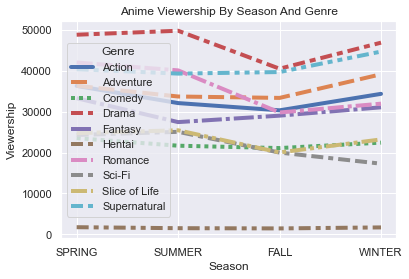

In [9]:
import seaborn as sns
from seaborn import lineplot
sns.set(rc={'figure.figsize':(11.7,8.27)})

lineplot(data=df_season,x="Season",y="Viewership",hue="Genre",style='Genre',size='Genre',sizes=(4,4)).set(title='Anime Viewership By Season And Genre')

Okay, well that's a hot mess. We can see which genres have higher average Viewership, but that's about it with this viz.

**Drama**, and **Supernatural** are the winners in terms of Viewership, and **Hentai** is the biggest loser

However, it's pretty hard to make out any interesting seasonal trends by genre

To see those, let's normalize each Genre by its average Viewership and then represent the season-to-season differenes as percents instead of absolute values. (That way the higher absolute Viewerships don't look skewed just because they have larger seasonal swings on an absolute scale)

In [10]:
viewership_offset_genre=df_season.groupby('Genre')['Viewership'].mean()
ranking_offset_genre=df_season.groupby('Genre')['Ranking'].mean()

df_norm=df_season.merge(viewership_offset_genre,on='Genre')
df_norm=df_norm.merge(ranking_offset_genre,on='Genre')

df_norm['Viewership']=(df_norm['Viewership_x']-df_norm['Viewership_y'])/df_norm['Viewership_y']
df_norm['Ranking']=(df_norm['Ranking_x']-df_norm['Ranking_y'])/df_norm['Ranking_y']

df_norm.drop(['Viewership_x','Viewership_y','Ranking_x','Ranking_y'],axis=1,inplace=True)

[Text(0.5, 1.0, 'Normalized Anime Viewership By Season And Genre')]

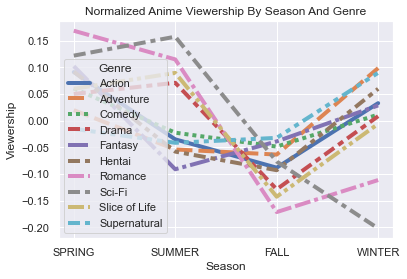

In [11]:
lineplot(data=df_norm,x="Season",y="Viewership",hue="Genre",style='Genre',size='Genre',sizes=(4,4)).set(title='Normalized Anime Viewership By Season And Genre')

What's interesting here is in *Summer*, some of the realistic genres like **Romance**, **Slice of Life**, and **Drama** gain more viewership, whereas **Fantasy**, **Adventure**, and **Supernatural** tend to have less relative Viewership. I wonder if that is due to the regular things in life like sunshine, hot dogs, and warm weather making real life seem not so bad. Whereas when it's cold, you'd rather choose something more escapist.

The clearest trend is generally all genres have an dip in Viewership in *Fall* and increase in *Winter*. That makes sense just with people staying inside more with the cold weather as well as New Years holidays.

The exception to that is **Supernatural** anime that come out in *Winter* have much worse viewership than any other time. 

I wonder if Rankings show the same trend

[Text(0.5, 1.0, 'Normalized Anime Viewership By Season And Genre')]

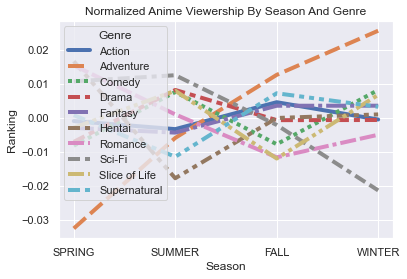

In [12]:
lineplot(data=df_norm,x="Season",y="Ranking",hue="Genre",style='Genre',size='Genre',sizes=(4,4)).set(title='Normalized Anime Viewership By Season And Genre')

In terms of Ratings, **Adventure** is rated very well in *Winter* relative to *Spring*. Not surprising that people would want to go on an adventure when they're stuck inside all **Winter**

We also see **Supernatural** again doing poorly in Ranking in *Winter* as well as in Viewership. I wonder if people have a hard time believing in gods in *Winter* when everything outside is cold and dead

**Romance** does especially well in the *Spring* in terms of Viewership and Rankings. I guess thats Why they call it the *"Season of Love"*

Let's look at change in popularity or ranking over the years

In [13]:
df_year=pd.DataFrame(columns=['index','Season','Viewership'])
for x in range(24,df_hot.shape[1]):
    colname = df_hot.columns[x]

    df_year_genre=df_hot[df_hot.iloc[:, x] == 1]

    series_plot_me_count=df_year_genre.groupby('seasonYear')['id'].count()
    series_plotme_sumPopularity=df_year_genre.groupby('seasonYear')['popularity'].sum()
    series_plotme_avgRanking=df_year_genre.groupby('seasonYear')['averageScore'].mean()
    df_year_genre=series_plotme_sumPopularity/series_plot_me_count

    df_year_genre=pd.DataFrame({ 'Year': df_year_genre.keys(), 'Viewership': df_year_genre.values, 'Ranking': series_plotme_avgRanking.values })
    # season_order = ["SPRING", "SUMMER", "FALL", "WINTER"]
    # df_year_genre=df_year_genre.reset_index().set_index("Season").loc[season_order]
    df_year_genre['Genre']=colname
    if df_year.empty:
        df_year=df_year_genre.copy(deep=True)
    else:
        df_year=pd.concat([df_year,df_year_genre])

df_year.reset_index(inplace=True)
df_year.drop(['index'],axis=1,inplace=True)
display(df_year.head(12))

,Year,Viewership,Ranking,Genre
0,2013.0,28133.116071,64.981132,Action
1,2014.0,36588.075188,64.929134,Action
2,2015.0,39021.805755,65.862319,Action
3,2016.0,29315.907514,64.668639,Action
4,2017.0,27983.333333,65.592593,Action
5,2018.0,33847.530488,63.662500,Action
6,2019.0,41140.275362,65.507576,Action
7,2020.0,37497.115385,65.208333,Action
8,2021.0,36203.186567,66.893443,Action
9,2022.0,18695.800000,65.760870,Action


[Text(0.5, 1.0, 'Anime Viewership By Year And Genre')]

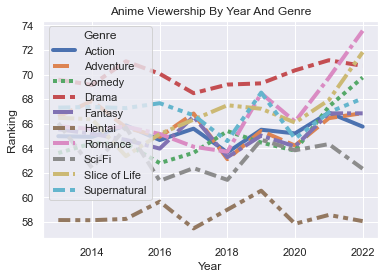

In [14]:
lineplot(data=df_year,x="Year",y="Ranking",hue="Genre",style='Genre',size='Genre',sizes=(4,4)).set(title='Anime Viewership By Year And Genre')

Wow! Since 2020 the **Romance**, **Comedy** and **Slice of Life** animes that have come out have garnered more viewership in 2021 and 2022 than they used to. That may be a sad story of people wanting a return to normal life and normal romance in the wake of the pandemic... or to just have a normal laugh.

No increase in the average viewership for a **Hentai** anime as people spent more time at home during the pandemic. Slighlty surprising, but promising.

Next let's take a look see if anime based on manga are more popular than original anime.

First let's see what all types of source material exist in this dataset. The column is called `source`

In [15]:
df_media.groupby('source').size().sort_values(ascending=False)

source
ORIGINAL        2715
MANGA           1839
OTHER            677
VIDEO_GAME       476
LIGHT_NOVEL      473
VISUAL_NOVEL     303
dtype: int64

Interesting, there's a few more options for source material than just manga. 

Let's see the average ranking of each

Text(0.5, 1.0, 'Anime Rankings By Source Material Type')

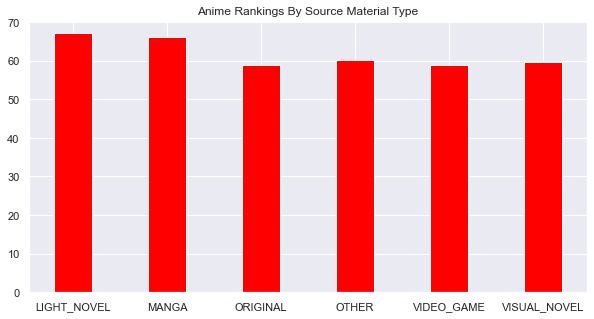

In [16]:
import matplotlib.pyplot as plt

df_media['averageScore']=pd.to_numeric(df_media['averageScore'])

summarize_popularity=df_media.groupby('source')['averageScore'].mean()

fig = plt.figure(figsize = (10, 5))
plt.bar(summarize_popularity.keys(), summarize_popularity.values, color ='red',
        width = 0.4)
plt.title('Anime Rankings By Source Material Type')

Surprisingly, not a huge difference in ranking between any genre. `LIGHT_NOVEL` and `MANGA` are slightly ahead but probably not significantly.

What about... Viewership?

Text(0.5, 1.0, 'Anime Viewership By Source Material Type')

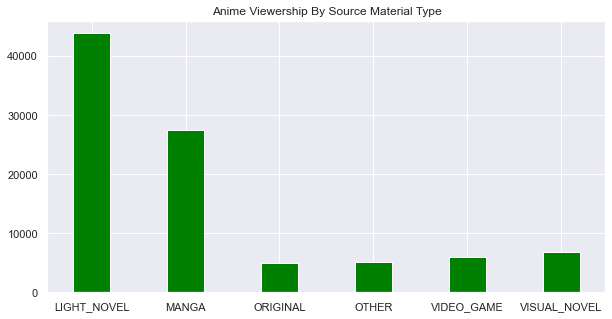

In [17]:
series_plot_me_count=df_media.groupby('source')['id'].count()
series_plotme_avgPopularity=df_media.groupby('source')['popularity'].sum()

df_plotme=series_plotme_avgPopularity/series_plot_me_count

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 5))
plt.bar(df_plotme.keys(), df_plotme.values, color ='green',
        width = 0.4)
plt.title('Anime Viewership By Source Material Type')

Wow okay, we've got a clear winner here as anime based on `LIGHT_NOVEL` have way more viewership than other source material types. Also we have a clear 2nd place in `MANGA`

I wonder if that's entirely fair to say or if there's more to that story. Let's trend these over the years and see...

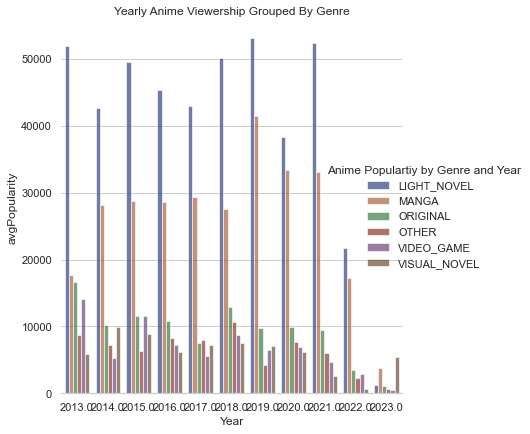

In [20]:
series_plot_me_count=df_media.groupby(['source','seasonYear'],as_index=False)['id'].count()
df_plotme=df_media.groupby(['source','seasonYear'],as_index=False)['popularity'].sum()
df_plotme['Viewership']=df_plotme['popularity']/series_plot_me_count['id']

pd.DataFrame({'Source':df_plotme['source']})


import seaborn as sns
sns.set_theme(style="whitegrid")

# df_media['avgPopularity']=df_media['avgPopularity']/df_media['avgPopularity']

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_plotme, kind="bar",
    x="seasonYear", y="Viewership", hue="source",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.set(title='Yearly Anime Viewership Grouped By Genre')
g.despine(left=True)
g.set_axis_labels("Year", "avgPopularity")
g.legend.set_title("Anime Populartiy by Genre and Year")

Wow, year over year, Anime based on `LIGHT_NOVEL` and `MANGA` out-perform others consistently, no outliers. That's very interesting.

In conclusion, I think we definitely were able to get some cool insights.

This was really fun to make as I love anime

Here is my myanimelist in case you want to know which anime I really like:

https://myanimelist.net/animelist/sprucemister

Thank you for reading!